In [1]:
# Import dataset and split
import pandas as pd

X = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250710_CompToStruct/data/input_model1.csv')
y = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250710_CompToStruct/data/output_model1.csv')

### Data Wrangler to drop material ID and one-hot-encode the space group and crystal structure categories

In [2]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(X):
    # Drop column: 'material_id'
    X = X.drop(columns=['material_id'])
    # Drop column: 'crystal_system'
    X = X.drop(columns=['crystal_system'])
    return X

X_clean = clean_data(X.copy())
X_clean.head()

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,5-norm,7-norm,10-norm,space_group,lattice_a,lattice_b,lattice_c,alpha,beta,gamma
0,14.0,14.0,0.0,14.0,0.0,14.0,78.0,78.0,0.0,78.0,...,1.0,1.0,1.0,P1,12.539835,12.336424,12.537087,77.158581,101.537034,106.471952
1,13.0,13.0,0.0,13.0,0.0,13.0,73.0,73.0,0.0,73.0,...,1.0,1.0,1.0,P1,12.125311,12.276289,12.134424,99.886852,94.492749,84.943404
2,14.0,14.0,0.0,14.0,0.0,14.0,78.0,78.0,0.0,78.0,...,1.0,1.0,1.0,P1,12.676976,12.182009,12.225709,80.759853,104.325951,78.831992
3,8.0,8.0,0.0,8.0,0.0,8.0,87.0,87.0,0.0,87.0,...,1.0,1.0,1.0,P1,4.930603,5.122182,7.899177,90.627352,91.068696,90.120427
4,8.0,8.0,0.0,8.0,0.0,8.0,87.0,87.0,0.0,87.0,...,1.0,1.0,1.0,P1,5.160296,5.240245,5.890213,90.235173,90.496808,90.257131


In [3]:
# one hot-encode
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_array = encoder.fit_transform(X_clean[['space_group']])
encoded_names = encoder.get_feature_names_out(['space_group'])
encoded_df = pd.DataFrame(encoded_array, columns=encoded_names, index = X_clean.index)

# Drop the pre-encoded feature and concat the encoded
X_clean = X_clean.drop(columns=['space_group'])
X_clean = pd.concat([X_clean, encoded_df], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_clean, y, test_size= 0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size= 0.5,random_state=42)

In [5]:
# Standardize dataset
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train_sc = scaler_X.fit_transform(X_train)
X_val_sc = scaler_X.transform(X_val)
X_test_sc = scaler_X.transform(X_test)
#cif_test_sc = scaler_X.transform(cif_test)

scaler_y = StandardScaler()
y_train_sc = scaler_y.fit_transform(y_train)
y_val_sc = scaler_y.transform(y_val)
y_test_sc = scaler_y.transform(y_test)

In [6]:
# Tensoring the dataset
import torch
from torch.utils.data import Dataset

class DataSet(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class InferenceDataset(torch.utils.data.Dataset):
    """
    For dataset containing only input, likely the CIF test file
    """
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

In [7]:
# Dataloader
from torch.utils.data import DataLoader

train_dataset = DataSet(X_train_sc, y_train_sc)
val_dataset = DataSet(X_val_sc, y_val_sc)
test_dataset = DataSet(X_test_sc, y_test_sc)
#cif_dataset = InferenceDataset(cif_test_sc)

train_loader = DataLoader(train_dataset, batch_size= 32, shuffle= True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size= 32, shuffle= False, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size= 32, shuffle= False, drop_last = True)
#cif_loader = DataLoader(cif_dataset, batch_size= 32, shuffle=False)

In [8]:
# Define torch model
import torch
import torch.nn as nn

class DFTRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.linear_relu_stack(x)

In [9]:
# Create model instance
model = DFTRegressor(input_dim= X_train.shape[1], output_dim= y_train.shape[1])
loss_fn = nn.SmoothL1Loss() # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [10]:
# training loop
def train(model, train_loader, val_loader, optimizer, loss_fn, n_epochs= 200):
    best_model_state = None
    best_val_loss = float('inf')

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)
                val_loss += loss.item()
    
        avg_train_loss = train_loss/len(train_loader)
        avg_val_loss = val_loss/len(val_loader)
            
        print(f"Epoch {epoch}: train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

    print(f' The best validation loss: {best_val_loss:.4f}')
    model.load_state_dict(best_model_state)
    return model

In [11]:
# Evaluation
import numpy as np

def test(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            test_loss += loss.item()

            all_preds.append(pred.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    avg_test_loss = test_loss/len(test_loader)
    pred = np.vstack(all_preds)
    target = np.vstack(all_targets)
    print(f'Test loss: {avg_test_loss:.4f}')
    return pred, target

In [12]:
# Run training - eval
best_model = train(model, optimizer= optimizer, train_loader=train_loader, val_loader= val_loader, loss_fn=loss_fn, n_epochs=100)

y_pred, y_true = test(best_model, test_loader, loss_fn)

Epoch 0: train loss: 436.9800, val loss: 3309.8726
Epoch 1: train loss: 379.4981, val loss: 3306.5765
Epoch 2: train loss: 354.5650, val loss: 3304.9929
Epoch 3: train loss: 338.0118, val loss: 3304.1326
Epoch 4: train loss: 326.0320, val loss: 3302.4073
Epoch 5: train loss: 316.3177, val loss: 3301.6654
Epoch 6: train loss: 307.9672, val loss: 3301.3516
Epoch 7: train loss: 300.7905, val loss: 3300.7914
Epoch 8: train loss: 294.6238, val loss: 3300.5680
Epoch 9: train loss: 289.4758, val loss: 3299.8528
Epoch 10: train loss: 285.2209, val loss: 3299.8224
Epoch 11: train loss: 280.0188, val loss: 3299.9749
Epoch 12: train loss: 276.7706, val loss: 3298.8318
Epoch 13: train loss: 272.5934, val loss: 3298.8052
Epoch 14: train loss: 269.8215, val loss: 3298.5747
Epoch 15: train loss: 266.4231, val loss: 3298.7381
Epoch 16: train loss: 263.9921, val loss: 3298.5996
Epoch 17: train loss: 261.4905, val loss: 3298.0388
Epoch 18: train loss: 258.9107, val loss: 3297.9337
Epoch 19: train loss: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

band_gap_x — RMSE: 0.8086, R²: 0.7152
formation_energy_per_atom_x — RMSE: 0.2909, R²: 0.9323
mean Voro_index_10 — RMSE: 0.2036, R²: 0.3800
mean Voro_vol_mean — RMSE: 240094336.0000, R²: -3961354446001141999281897472.0000
std_dev Voro_area_std_dev — RMSE: 1545327104.0000, R²: -40064592302861002272145408.0000
std_dev Voro_dist_mean — RMSE: 0.0745, R²: 0.7292
mean Voro_dist_maximum — RMSE: 0.2886, R²: 0.7687
std_dev Voro_dist_maximum — RMSE: 0.1829, R²: 0.6179
density_x — RMSE: 0.4441, R²: 0.9737
vpa — RMSE: 4.3429, R²: 0.7615

Average RMSE: 178542144.0000
Average R²: -400141903830400270090633216.0000


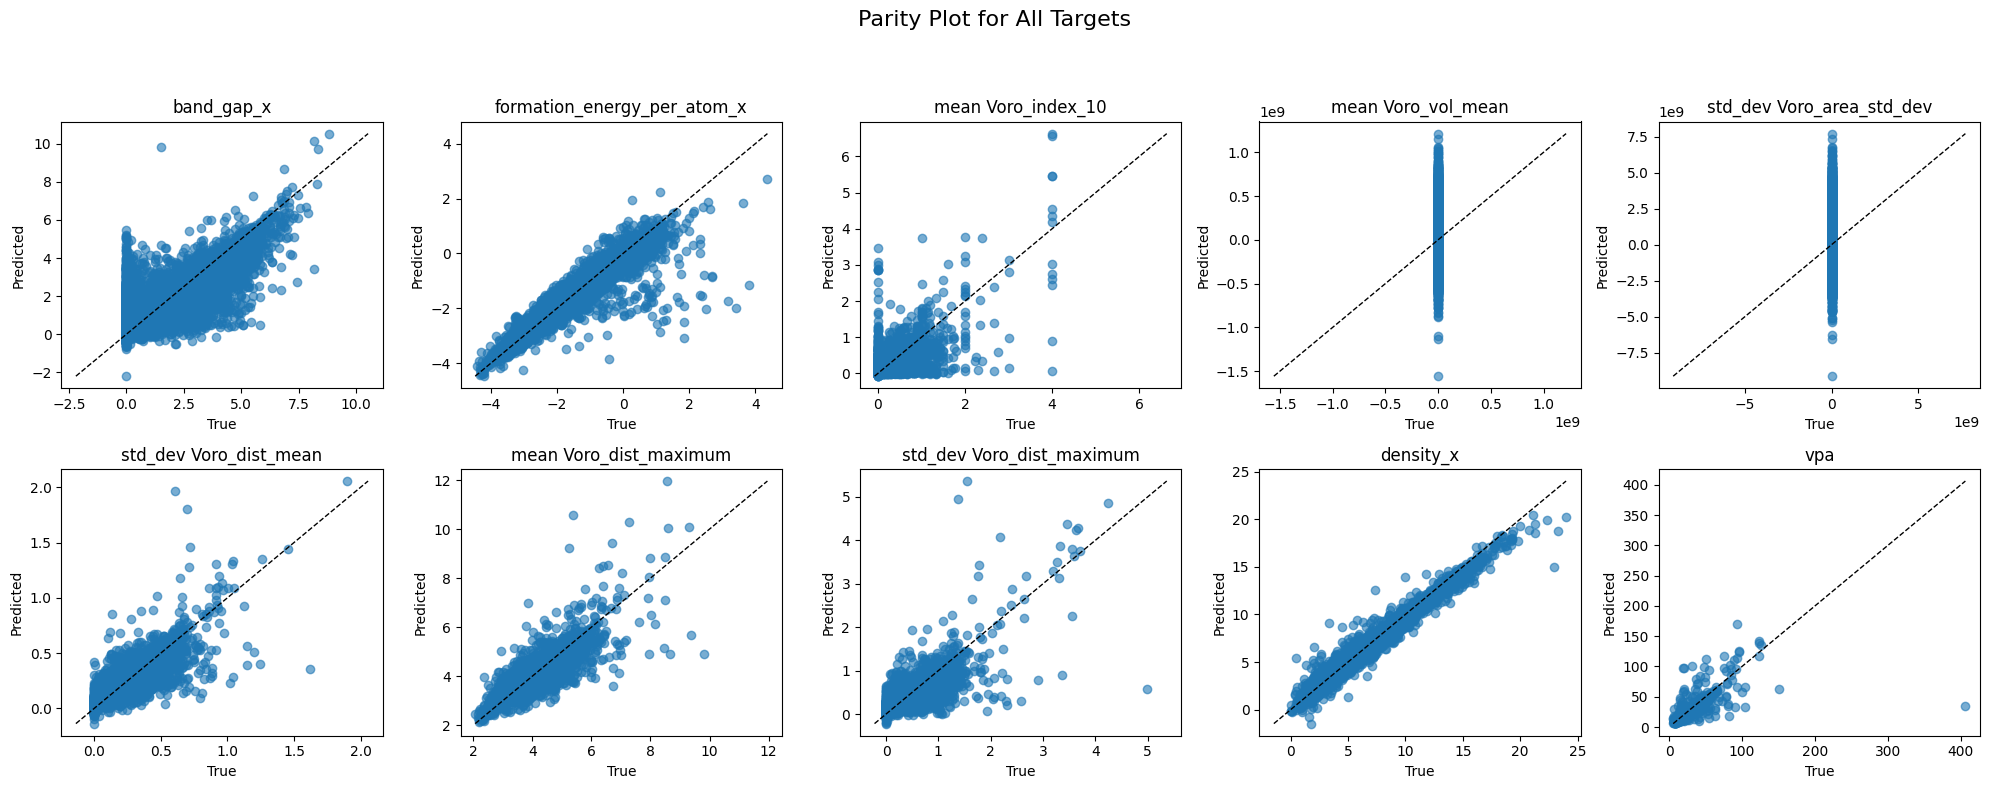

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Inverse transform if targets were standardized
y_true_orig = scaler_y.inverse_transform(y_true)
y_pred_orig = scaler_y.inverse_transform(y_pred)

# Get target names from original DataFrame
target_names = y_train.columns.tolist()

# Evaluate RMSE and R²
n_targets = y_true_orig.shape[1]
rmse_list = []
r2_list = []

for i in range(n_targets):
    rmse = mean_squared_error(y_true_orig[:, i], y_pred_orig[:, i], squared=False)
    r2 = r2_score(y_true_orig[:, i], y_pred_orig[:, i])
    rmse_list.append(rmse)
    r2_list.append(r2)
    print(f"{target_names[i]} — RMSE: {rmse:.4f}, R²: {r2:.4f}")

print(f"\nAverage RMSE: {np.mean(rmse_list):.4f}")
print(f"Average R²: {np.mean(r2_list):.4f}")

# Plot parity plots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Parity Plot for All Targets", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.scatter(y_true_orig[:, i], y_pred_orig[:, i], alpha=0.6)
    min_val = min(y_true_orig[:, i].min(), y_pred_orig[:, i].min())
    max_val = max(y_true_orig[:, i].max(), y_pred_orig[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax.set_title(target_names[i])
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted") 

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
import shap

# After training
explainer = shap.DeepExplainer(model, )
shap_values = explainer.shap_values(X)

# Convert to numpy if needed
shap_values = shap_values[0]  # DeepExplainer returns a list

# SHAP summary plot
shap.summary_plot(shap_values, X.columns)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataSet